---
title: "Features"
jupyter: python3
---

Let's see some of **Specification Curve**'s features in action.

In [1]:
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

## Basic Use

Here's an example of using **Specification Curve**. Note that, in the below, we can pass strings or lists of string into the arguments of the class `SpecificationCurve`. The programme then automatically performs all of possible regressions of endogeneous variables on exogeneous variables and controls. The estimate that is picked out is the coefficient on the given combination of endogeneous and exogenous variables (with conditioning on the given controls).

If a control variable is categorical, rather than continuous, it will be treated as a fixed effect.

Fit complete


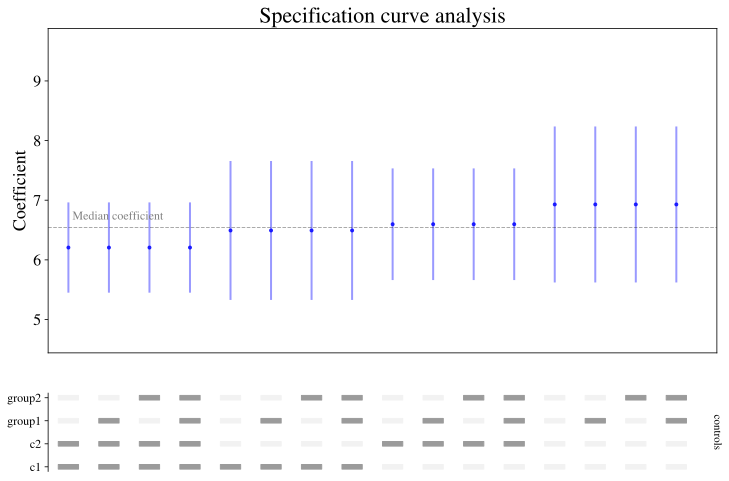

In [2]:
import specification_curve as specy

df = specy.load_example_data1()
y_endog = "y1"  # endogeneous variable
x_exog = "x1"  # exogeneous variable
controls = ["c1", "c2", "group1", "group2"]
sc = specy.SpecificationCurve(
    df,
    y_endog,
    x_exog,
    controls,
)
sc.fit()
sc.plot()

Grey squares (black lines when there are many specifications) show whether a variable is included in a specification or not. Blue or red markers and error bars show whether the coefficient is positive and significant (at the 0.05 level) or red and significant, respectively.



## Retrieving estimates

You can retrieve the estimates from the data frame:

In [3]:
sc = specy.SpecificationCurve(df, y_endog, x_exog, controls)
sc.fit()
sc.df_r.head()

Fit complete


,x_exog,y_endog,Results,Coefficient,Specification,bse,conf_int,pvalues,SpecificationCounts
Specification No.,,,,,,,,,
0,x1,y1,<statsmodels.regression.linear_model.Regressio...,6.205962,"[c1, c2, x1, y1]",0.385317,"[5.448896340566625, 6.963027714134414]","{'x1': 3.357166814264534e-47, 'c1': 4.04817525...","{'c1': 1, 'c2': 1, 'x1': 1, 'y1': 1}"
1,x1,y1,<statsmodels.regression.linear_model.Regressio...,6.205962,"[c1, c2, group1, x1, y1]",0.385317,"[5.448896340566625, 6.963027714134414]","{'x1': 3.357166814264534e-47, 'c1': 4.04817525...","{'c1': 1, 'c2': 1, 'group1': 1, 'x1': 1, 'y1': 1}"
2,x1,y1,<statsmodels.regression.linear_model.Regressio...,6.205962,"[c1, c2, group2, x1, y1]",0.385317,"[5.448896340566625, 6.963027714134414]","{'x1': 3.357166814264534e-47, 'c1': 4.04817525...","{'c1': 1, 'c2': 1, 'group2': 1, 'x1': 1, 'y1': 1}"
3,x1,y1,<statsmodels.regression.linear_model.Regressio...,6.205962,"[c1, c2, group1, group2, x1, y1]",0.385317,"[5.448896340566625, 6.963027714134414]","{'x1': 3.357166814264534e-47, 'c1': 4.04817525...","{'c1': 1, 'c2': 1, 'group1': 1, 'group2': 1, '..."
4,x1,y1,<statsmodels.regression.linear_model.Regressio...,6.492386,"[c1, x1, y1]",0.592879,"[5.327511339458264, 7.657260911796476]","{'x1': 3.922713328081985e-25, 'c1': 2.18937700...","{'c1': 1, 'x1': 1, 'y1': 1}"


## Saving results to file

Save the plot to file (the format is inferred from file extension):

```python
sc = specy.SpecificationCurve(df, y_endog, x_exog, controls,
                                  cat_expand=['group1'])
sc.fit()
sc.plot(save_path='test_fig.pdf')
```

## Expanding a categorical variable

Should you need to, you can expand a categorical variable into its different elements and run those separately. In the example below, the `"group2"` categorical variable is expanded like this.

Fit complete


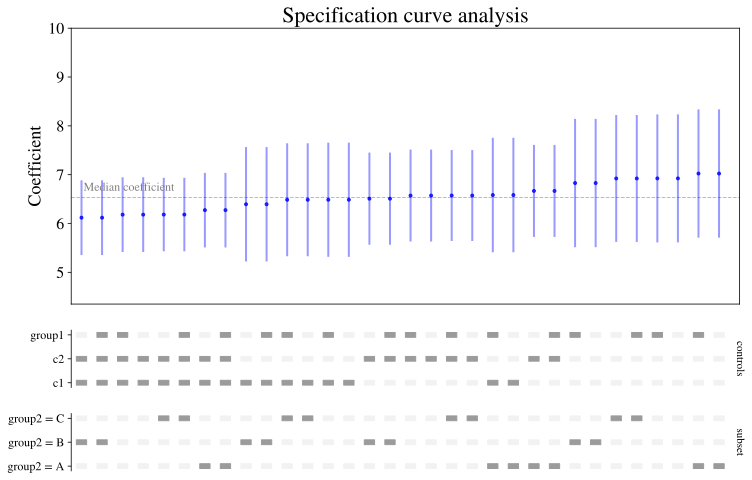

In [4]:
y_endog = "y1"  # endogeneous variable
x_exog = "x1"  # exogeneous variable
controls = ["c1", "c2", "group1", "group2"]
sc = specy.SpecificationCurve(
    df,
    y_endog,
    x_exog,
    controls,
    cat_expand=["group2"],  # have each fixed effect run separately
)
sc.fit()
sc.plot()

## Using multiple exogeneous variables

Sometimes, you'd like to check different independent variables (and the coefficients they come with following a regression). This is achieved by passing a list to the exogeneous argument of `SpecificationCurve`. These variations on the independent variables are labelled by `x` in the plot.

Fit complete


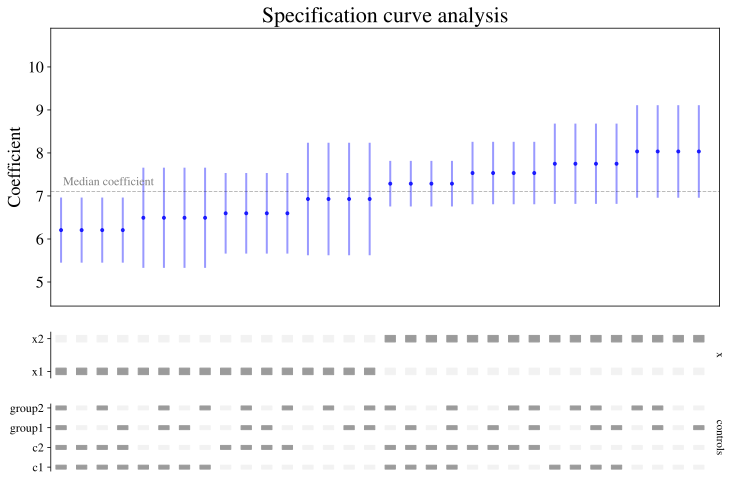

In [5]:
df = specy.load_example_data1()
x_exog = ["x1", "x2"]
y_endog = "y1"
controls = ["c1", "c2", "group1", "group2"]
sc = specy.SpecificationCurve(df, y_endog, x_exog, controls)
sc.fit()
sc.plot()

## Excluding some combinations of controls

Some controls may be redundant, and you might want to exclude them both being used together. The `exclu_grps` keyword argument achieves this.

In the below example, `"c1"` and `"c2"` are never run in the same specification.

Fit complete


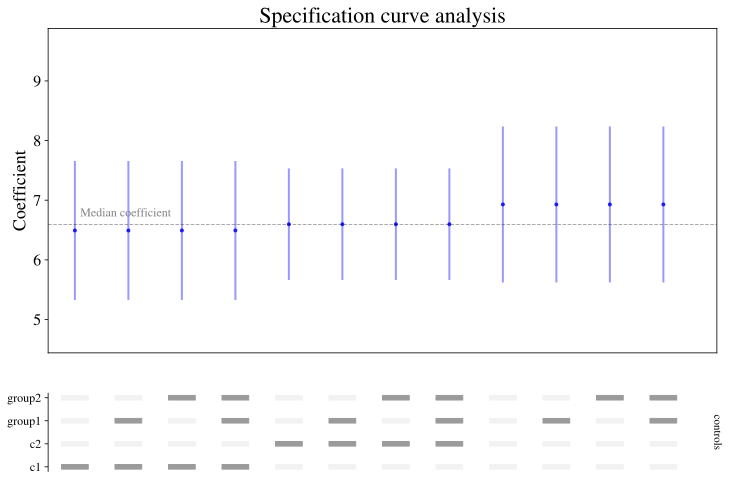

In [6]:
df = specy.load_example_data1()

y_endog = "y1"
x_exog = "x1"
controls = ["c1", "c2", "group1", "group2"]
sc = specy.SpecificationCurve(df, y_endog, x_exog, controls, exclu_grps=[["c1", "c2"]])
sc.fit()
sc.plot()

## Always include some controls in all specifications

Likewise, there will be times when you always wish to include a particular control in specifications, and to show this on the plot. The `always_include=` keyword argument helps you to achieve this.

In the example below, we ask that `"c1"` is included in every specification.

Fit complete


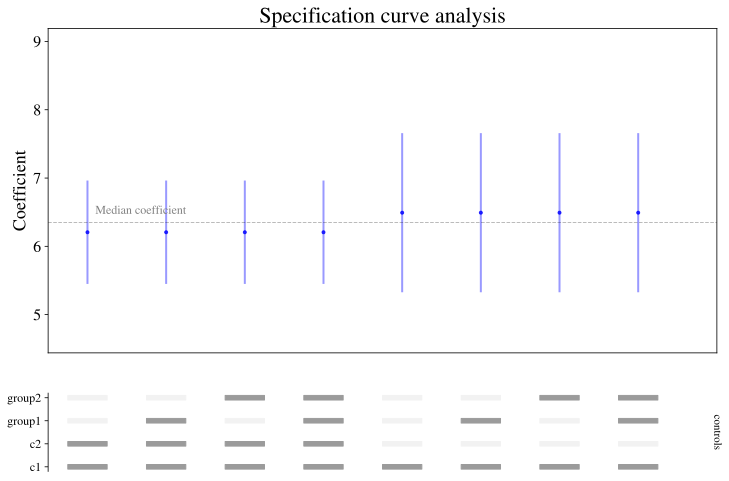

In [7]:
df = specy.load_example_data1()
x_exog = "x1"
y_endog = "y1"
controls = ["c2", "group1", "group2"]
sc = specy.SpecificationCurve(df, y_endog, x_exog, controls, always_include="c1")
sc.fit()
sc.plot()

## Flexing the style for very large numbers of specifications

The default plot type isn't suitable for very large numbers of specifications, but it does automatically switch to a style suited to a large number of specifications.

Here's an example

In [8]:
import numpy as np
import pandas as pd

# Set seed for random numbers
seed_for_prng = 78557
# prng=probabilistic random number generator
prng = np.random.default_rng(seed_for_prng)

Fit complete


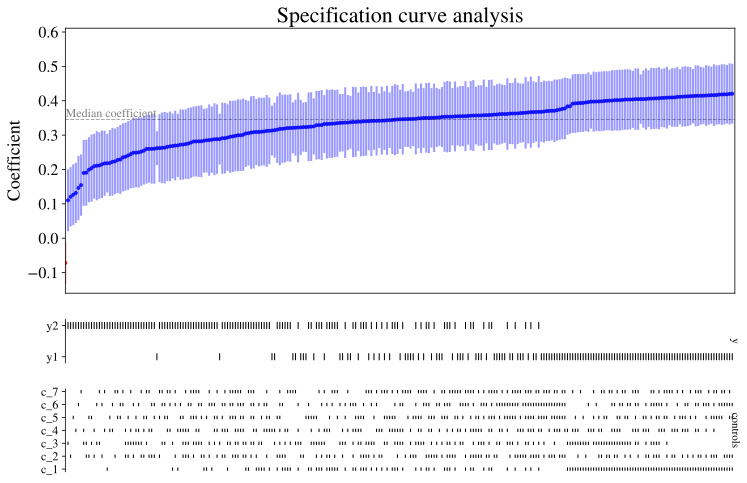

In [9]:
# Generate some fake data

n_samples = 400
# Number of dimensions of continuous
n_dim = 8
c_rnd_vars = prng.random(size=(n_dim, n_samples))
c_rnd_vars_names = [f"c_{i}" for i in range(np.shape(c_rnd_vars)[0])]
y_1 = (
    0.4 * c_rnd_vars[0, :]  # This is the true value of the coefficient
    - 0.2 * c_rnd_vars[1, :]
    + 0.3 * prng.standard_normal(n_samples)
)
# Next line causes y_2 ests to be much more noisy
y_2 = y_1 - 0.3 * np.abs(prng.standard_normal(n_samples))
df = pd.DataFrame([y_1, y_2], ["y1", "y2"]).T
for i, col_name in enumerate(c_rnd_vars_names):
    df[col_name] = c_rnd_vars[i, :]

controls = c_rnd_vars_names[1:]

# Run it with Specification Curve
sc = specy.SpecificationCurve(df, ["y1", "y2"], c_rnd_vars_names[0], controls)
sc.fit()
sc.plot()

## Flagging a preferred specification

Often, in practice, you will have a *preferred* specification that you will use as your estimate. You can specify this and have it be flagged.

You can achieve this by passing a list of variables that you'd like to be used in your preferred specification via the `preferred_spec` keyword argument.

In the example below, the preferred specification comes out as being close to the known answer that we constructed.

Fit complete


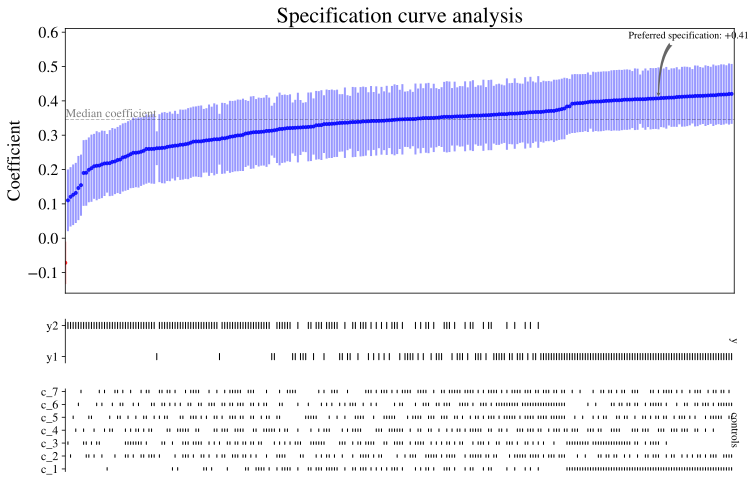

In [10]:
sc = specy.SpecificationCurve(df, ["y1", "y2"], c_rnd_vars_names[0], controls)
sc.fit()
sc.plot(preferred_spec=["y1", c_rnd_vars_names[0]] + controls)

## Using models other than Ordinary Least Squares

The default model is OLS, but you can pass through other models too.

Optimization terminated successfully.
         Current function value: 0.325863
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.324867
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.325858
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.322285
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.324788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.317532
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.321525
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.317330
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330088
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329788
  

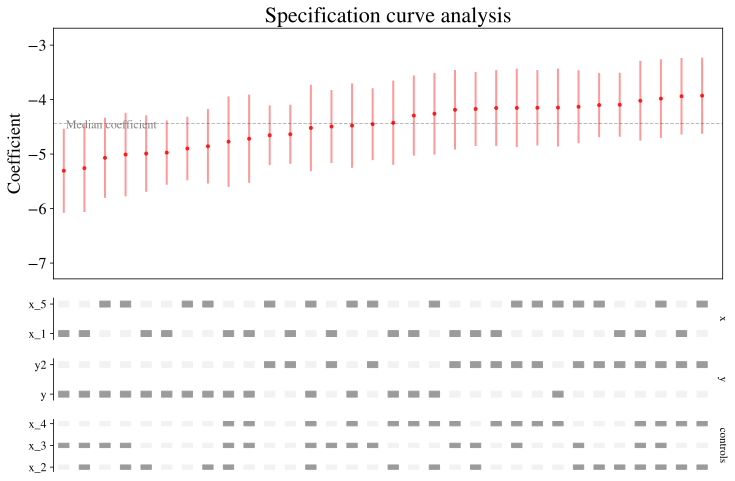

In [11]:
import statsmodels.api as sm

# generate some fake data
n_samples = 1000
x_2 = prng.integers(2, size=n_samples)
x_1 = prng.random(size=n_samples)
x_3 = prng.integers(3, size=n_samples)
x_4 = prng.random(size=n_samples)
x_5 = x_1 + 0.05 * np.random.randn(n_samples)
x_beta = -1 - 3.5 * x_1 + 0.2 * x_2 + 0.3 * x_3  # NB: coefficient is -3.5
prob = 1 / (1 + np.exp(-x_beta))
y = prng.binomial(n=1, p=prob, size=n_samples)
y2 = prng.binomial(n=1, p=prob * 0.98, size=n_samples)
df = pd.DataFrame(
    [x_1, x_2, x_3, x_4, x_5, y, y2], ["x_1", "x_2", "x_3", "x_4", "x_5", "y", "y2"]
).T


# Specify the regressions to run
y_endog = ["y", "y2"]
x_exog = ["x_1", "x_5"]
controls = ["x_3", "x_2", "x_4"]
sc = specy.SpecificationCurve(df, y_endog, x_exog, controls)
# Fit using the logit estimator
sc.fit(estimator=sm.Logit)  # sm.Probit also works
sc.plot()